## LDA K-Fold Cross Validation
### Plot ROC Curve with Optimal Cutoffs and Accuracy Rates
John Bonfardeci
2017-04-09

#### What this notebook does:
* Create randomized K cross-validation (CV) groups
* For-each CV:
    * Split randomized data into (k-1)/k training data and 1/k testing
    * Run LDA K times
        * Find best cutoff (Youden's Index and Distance-to-corner) and test cutoff set
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
    
    * Run Logistic Regression K times
        * Find best cutoff (Youden's Index and Distance-to-corner) and test cutoff set
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
    
Directions in Jupyter Notebook: Select `Cell -> Run All`. 
Look for printed output and ROC plots at bottom of notebook.

In [1]:
# Change These Parameters

# relative file path; can place in same working directory as notebook
file_path = 'hof_data.csv'

# the column names of the continuous predictors
feature_names = ['H','HR','RBI','AVG','SLG','OBP']

# the column names of the categorical predictors
categorical_features = ['POS'] # DOES NOT HANDLE CATEGORICAL PREDICTORS AT THIS TIME
# ...here's why: 
# http://stats.stackexchange.com/questions/158772/can-we-use-categorical-independent-variable-in-discriminant-analysis#158781)

# name of target column
target_name = 'HOF'

# what value represents the positive value in a binary response: e.g. 1, 'Y', 'T', ...
target_value = 'Y' 

# test thresholds to try
test_cutoffs = [0.10, 0.25, 0.50, 0.75, 0.90] 

# LDA Solver to use. 
#    Options: 
#        'lsqr' (Least squares solution) - can use with shrikage
#        'svd' (Singular value decomposition) - use with large num features
#        'eigen' (Eigenvalue decomposition) - can use with shrikage
# http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
lda_solver = 'lsqr'

# change to None to run LDA without shrinkage
# Options: None, 'auto', float between 0 and 1
# see http://scikit-learn.org/stable/auto_examples/classification/plot_lda.html#sphx-glr-auto-examples-classification-plot-lda-py
lda_shrinkgage = 'auto'

# number of cross-validation groups to run
num_cv = 5

output_data_to_excel = True


All of the links below proved helpful in the researh for writing this notebook.
* http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
* https://en.wikipedia.org/wiki/Sensitivity_and_specificity
* https://en.wikipedia.org/wiki/Youden%27s_J_statistic
* http://stats.stackexchange.com/questions/29719/how-to-determine-best-cutoff-point-and-its-confidence-interval-using-roc-curve-i
* http://support.sas.com/kb/25/018.html
* http://support.sas.com/resources/papers/proceedings10/222-2010.pdf
* https://sasshowcase.wordpress.com/category/sas-macro/
* http://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
* https://www.medcalc.org/manual/roc-curves.php
* http://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/One_ROC_Curve_and_Cutoff_Analysis.pdf
* http://www.umich.edu/~ners580/ners-bioe_481/lectures/pdfs/1978-10-semNucMed_Metz-basicROC.pdf
* http://scikit-learn.org/stable/modules/cross_validation.html
* http://stats.stackexchange.com/questions/95797/how-to-split-the-dataset-for-cross-validation-learning-curve-and-final-evaluat
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
* http://gim.unmc.edu/dxtests/roc2.htm
* https://codeyarns.com/2014/10/27/how-to-change-size-of-matplotlib-plot/
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [2]:
# DON'T change below this line unless you know what your're doing.

import math
import pandas as pd
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
import random
from copy import copy

from sklearn import datasets
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [3]:
# load the data into Pandas Dataframe object
usecols = copy(feature_names).append(target_name)

df = pd.read_csv(file_path, usecols=usecols) # returns new Pandas DataFrame 

# randomize rows (http://quabr.com/29576430/shuffle-dataframe-rows)
#df = _df.iloc[np.random.permutation(len(df))]

# create new series with target value converted to 1/0 for the binary responses
y = pd.Series( map(lambda x: 1 if x == target_value else 0, df[target_name]) ).as_matrix() # <class 'pandas.core.series.Series'>

# get our predictor variables as a multidimensional array (matrix)
X = df[feature_names].as_matrix() # <class 'pandas.core.frame.DataFrame'>

cat = df[categorical_features].as_matrix() # <class 'pandas.core.frame.DataFrame'>

# check the X and y data
print y[0:5]
print X[0:5]

# good to go...

[1 0 0 0 0]
[[3771  755 2297  305  555  374]
 [1022   57  366  254  347  292]
 [1832  336 1122  277  485  337]
 [ 999  130  433  255  412  320]
 [ 260   37  109  236  393  304]]


In [4]:
# Optimal Cutoff (Threshold) Methods

def invert_fpr(fpr):
    """ Invert (1-specificity) to specificity"""
    return 1.0 - fpr


def get_youdens_cutoff(tpr, fpr, cutoffs):
    """
    Youden's Index. Value with highest Youden's index indicates optimal cutoff point.
    http://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/One_ROC_Curve_and_Cutoff_Analysis.pdf
    
    @param tpr: array<float> (True Positive Rate - the Sensitivity)
    @param fpr: array<float> (False Positive Rate - the Specificity)
    @param thresholds array<float> (list of thresholds)
    @returns dict
    """
    
    def fn(tpr, fpr):
        return tpr - fpr
    
    d = {'method': 'Youden\'s Index', 
         'cutoff': 0,
         'tpr': 0, 
         'fpr': 0
        }
    
    # get values where tpr < 1.0
    t, f, c = tpr[tpr < 1.0], fpr[tpr < 1.0], cutoffs[tpr < 1.0]
    
    opt = fn(t[0], f[0])

    for (_tpr, _fpr, cutoff) in zip(t, f, c):
        n = fn(_tpr, _fpr)
        if n > opt:
            opt = n
            d['cutoff'] = cutoff
            d['tpr'] = _tpr
            d['fpr'] = _fpr
            
    return d

def get_youdens_test():
    test = [1.0, 0.99, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
    test_tpr = np.asarray(test)
    test_fpr = np.asarray(test.reverse())
    return get_youdens_cutoff(test_tpr, test_fpr, 0.1)
    
# print get_youdens_test()

In [5]:
def get_dist_cutoff(tpr, fpr, cutoffs):   
    """
    Distance to Corner. Lowest distance to upper-left corner is optimal cutoff.
    http://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/One_ROC_Curve_and_Cutoff_Analysis.pdf
    
    @param tpr: array<float> (True Positive Rate - the Sensitivity)
    @param fpr: array<float> (False Positive Rate - the Specificity)
    @param thresholds array<float> (list of thresholds)
    @returns dict
    """
    
    def fn(tpr, fpr): 
        return math.sqrt( math.pow(1.00-tpr, 2) + math.pow(fpr, 2) )
    
    d = {'method': 'Distance to Corner', 
         'cutoff': 0,
         'tpr': 0, 
         'fpr': 0
        }
    
    # get values where tpr < 1.0
    t, f, c = tpr[tpr < 1.0], fpr[tpr < 1.0], cutoffs[tpr < 1.0]
    
    opt = fn(t[0], f[0])

    for (_tpr, _fpr, cutoff) in zip(t, f, c):
        n = fn(_tpr, _fpr)
        if n < opt:
            opt = n
            d['cutoff'] = cutoff
            d['tpr'] = _tpr
            d['fpr'] = _fpr
              
    return d

In [6]:
def get_misclass_rate(cm):
    return float(cm[0][0] + cm[1][1]) / float(cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])

# Confusion Matrix
def get_confusion_matrix(cutoff, actual, predicted):
    """
    Putting a threshold/cutoff on the output of a regression problem, 
    to determine whether the value is greater or lower than a fixed threshold, 
    is a binary classification problem.
    
    For example: 
    
       n=165   | Predicted NO | Predicted YES
    ------------------------------------------
    Actual NO  |       50     |      10       |
    ------------------------------------------
    Actual YES |       5      |      100      |
    ------------------------------------------
    
    """
    pred = []
    
    df = pd.DataFrame(data=[], columns=[''])
    
    for (x, y) in predicted:
        pred.append(1 if x > cutoff else 0)

    return confusion_matrix(actual, pred) 


def get_cutoff_index(cutoffs, cutoff, tol=0.1): 
    i = 0
    for c in cutoffs:
        if c >= cutoff and c <= (cutoff+tol):
            return i
        
        i += 1
        
    return -1    

In [7]:
def output_cutoffs(fold_num, tpr, fpr, thresholds, prob):
    # output optimal cutoff/threshold points
    print "Fold %d" % (fold_num+1)
    print "------"
    
    # output a couple of standard algortithms for finding optimal cutoff points: Youden's and Distance-to-corner
    youdens = get_youdens_cutoff(tpr, fpr, thresholds)
    youdens_cm = get_confusion_matrix(youdens['cutoff'], y[test], prob)
    print "Youden's Index cutoff = %0.5f" % (youdens['cutoff'])
    print "Sensitivity: %0.5f, 1-Specificity: %0.5f" % (youdens['tpr'], youdens['fpr'])
    print "Confusion matrix:"
    print youdens_cm
    print "Misclassification Rate: %0.5f" % (get_misclass_rate(youdens_cm))
    
    print "\r\n"
    
    dtc = get_dist_cutoff(tpr, fpr, thresholds)
    dtc_cm = get_confusion_matrix(dtc['cutoff'], y[test], prob)
    print "Distance-to-corner cutoff = %0.5f" % (dtc['cutoff'])
    print "Sensitivity: %0.5f, 1-Specificity: %0.5f" % (dtc['tpr'], dtc['fpr'])
    print "Confusion matrix:"
    print dtc_cm
    print "Misclassification Rate: %0.5f" % (get_misclass_rate(dtc_cm))
       
    # Use the test cutoffs
    for cutoff in test_cutoffs:
        index = get_cutoff_index(thresholds, cutoff, 0.5)
        print "\r\n"
        print "When threshold = %0.2f:" % (cutoff)
        if index > -1:
            print "Sensitivity: %0.5f, 1-Specificity: %0.5f" % (tpr[index], fpr[index])
            
        cm = get_confusion_matrix(cutoff, y[test], prob)
        print cm
        print "Misclassification Rate: %0.5f" % (get_misclass_rate(cm))
    

    print "\r\n"

In [8]:
#Output to Excel
def output_excel(filename, prob, x, y, sheetname='Sheet1'):

    col_names = np.append( np.asarray(feature_names), np.asarray(['Y', 'ProbX', 'ProbY']))    
    data = []
    
    #print "\r\nprob: %d, x: %d, y: %d, fpr: %d, tpr: %d, thresh: %d" % (len(prob), len(x), len(y), len(fpr), len(tpr), len(thresholds))
    
    i = 0
    for xrow, yrow, prob in zip(x, y, prob):
        a = []
        for col in xrow:
            a.append(col)

        a.append(yrow)
        a.append(prob[0])
        a.append(prob[1])
        data.append(a)
        i+=1

    df = pd.DataFrame(data=data, columns=col_names)
    writer = pd.ExcelWriter(filename+'.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name=sheetname)
    writer.save()
    

def output_roc(filename, sheetname, tpr, fpr, cutoffs):
    #print "tpr: %d, fpr: %d, cutoffs: %d" % (len(tpr), len(fpr), len(cutoffs))
    
    data = []
    for (t, f, c) in zip(tpr, fpr, cutoffs):
        data.append([t, f, c])
        
    df = pd.DataFrame(data=data, columns=['Sensitivity', '1-Specificity', 'Cutoff'])
    writer = pd.ExcelWriter(filename+'.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name=sheetname)
    writer.save()
    

In [9]:
# Run LDA with cross-validation and plot ROC curves
rand = np.random.RandomState(0)

cv = StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=rand)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.

# ROC line colors
colors = cycle(['cyan', 'red', 'seagreen', 'darkorange', 'blue'])
lw = 2 # line width

i = 0
# For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
# TODO - add feature selection per CV
# train, test are of type <type 'numpy.ndarray'>
mean_accuracy = 0
for (train, test), color in zip(cv.split(X, y), colors):

    # train LDA on training dataset
    lda = LinearDiscriminantAnalysis(solver=lda_solver,  
                                     shrinkage=lda_shrinkgage).fit(X[train], y[train])
       
    # test LDA on test dataset
    prob = lda.predict_proba(X[test]) # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
    
    # gives you the predicted label for each sample
    # default threshold/cutoff is 0.5?
    yhat = lda.predict(X[test]) 
    
    # Compute ROC curve and area the curve
    # fpr = false positive rate (1-specificity)
    # tpr = true positive rate (sensitivity)
    fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1]) # returns <type 'numpy.ndarray'> x 3
    
    # add mean Sensitivity
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
    # get Area Under Curve
    roc_auc = auc(fpr, tpr)
    
    output_cutoffs(i, tpr, fpr, thresholds, prob)
    
    accuracy = lda.score(X[test], y[test])
    mean_accuracy += accuracy
    print "Mean Accuracy of LDA Fold %d = %0.5f" % (i+1, accuracy)
    
    if output_data_to_excel:
        output_excel('lda-fold-%d-test' % (i+1), prob, X[test], y[test], 'TestSet%d' % (i+1))
        output_excel('lda-fold-%d-train' % (i+1), lda.predict_proba(X[train]), X[train], y[train], 'TrainSet%d' % (i+1))
        output_roc('lda-roc-fold-%d-test'%(i+1), 'TestSet%d'%(i+1), tpr, fpr, thresholds)
    # /if...
    
    # Plot the ROC Curve for this CV group
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    i += 1
#/for (train, test)...

print "\r\nMean Accuracy of LDA is %0.5f.\r\n" % (mean_accuracy/num_cv) 

C:\Users\bonfardeci-j\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Fold 1
------
Youden's Index cutoff = 0.34756
Sensitivity: 0.90000, 1-Specificity: 0.01546
Confusion matrix:
[[  1 193]
 [  6   4]]
Misclassification Rate: 0.02451


Distance-to-corner cutoff = 0.34756
Sensitivity: 0.90000, 1-Specificity: 0.01546
Confusion matrix:
[[  1 193]
 [  6   4]]
Misclassification Rate: 0.02451


When threshold = 0.10:
Sensitivity: 0.70000, 1-Specificity: 0.00515
[[  1 193]
 [  5   5]]
Misclassification Rate: 0.02941


When threshold = 0.25:
Sensitivity: 0.70000, 1-Specificity: 0.00515
[[  1 193]
 [  6   4]]
Misclassification Rate: 0.02451


When threshold = 0.50:
Sensitivity: 0.10000, 1-Specificity: 0.00000
[[  1 193]
 [  6   4]]
Misclassification Rate: 0.02451


When threshold = 0.75:
Sensitivity: 0.10000, 1-Specificity: 0.00000
[[  4 190]
 [  9   1]]
Misclassification Rate: 0.02451


When threshold = 0.90:
Sensitivity: 0.10000, 1-Specificity: 0.00000
[[ 14 180]
 [  9   1]]
Misclassification Rate: 0.07353


Mean Accuracy of LDA Fold 1 = 0.97549
Fold 2
------
Y

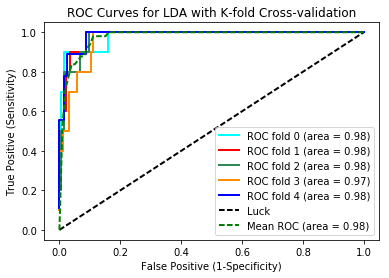

In [10]:
# Plot the ROC Curve for LDA
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')

num_cv_splits = cv.get_n_splits(X, y) #5

mean_tpr /= num_cv_splits
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive (1-Specificity)')
plt.ylabel('True Positive (Sensitivity)')
plt.title('ROC Curves for LDA with K-fold Cross-validation')
plt.legend(loc="lower right")

# change size of plot
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [11]:
# Run logistic Regression with cross-validation and plot ROC curves
i=0
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
mean_accuracy = 0
for (train, test), color in zip(cv.split(X, y), colors):

    logreg = LogisticRegression(C=1e5)
    logreg.fit(X[train], y[train])
    prob = logreg.predict_proba(X[test])
    yhat = logreg.predict(X[test])

    # Compute ROC curve and area the curve
    # fpr = false positive rate (1-specificity)
    # tpr = true positive rate (sensitivity)
    fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1]) # returns <type 'numpy.ndarray'> x 3
    
    # add mean Sensitivity
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
    # get Area Under Curve
    roc_auc = auc(fpr, tpr)
    
    output_cutoffs(i, tpr, fpr, thresholds, prob)
    
    #print "Confidence Scores:"
    #print logreg.decision_function(X[test])
    
    #print "\r\nParameters:"
    #print logreg.get_params(True)
    
    accuracy = logreg.score(X[test], y[test])
    print "Mean Accuracy of Log Reg Fold %d is %0.5f" % (i+1, accuracy)

    mean_accuracy += accuracy
    
    if output_data_to_excel:
        output_excel('logit-fold-%d-test' % (i+1), prob, X[test], y[test], 'TestSet%d' % (i+1))
        output_excel('logit-fold-%d-train' % (i+1), lda.predict_proba(X[train]), X[train], y[train], 'TrainSet%d' % (i+1))
        output_roc('logit-roc-fold-%d-test'%(i+1), 'TestSet%d'%(i+1), tpr, fpr, thresholds)
    # /if...
    
    # Plot the ROC Curve for this CV group
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
#/for (train, test)...

print "\r\nMean Accuracy of Log Reg is %0.5f.\r\n" % (mean_accuracy/num_cv) 

Fold 1
------
Youden's Index cutoff = 0.18122
Sensitivity: 0.90000, 1-Specificity: 0.03093
Confusion matrix:
[[  1 193]
 [  4   6]]
Misclassification Rate: 0.03431


Distance-to-corner cutoff = 0.18122
Sensitivity: 0.90000, 1-Specificity: 0.03093
Confusion matrix:
[[  1 193]
 [  4   6]]
Misclassification Rate: 0.03431


When threshold = 0.10:
Sensitivity: 0.70000, 1-Specificity: 0.00515
[[  0 194]
 [  4   6]]
Misclassification Rate: 0.02941


When threshold = 0.25:
Sensitivity: 0.70000, 1-Specificity: 0.00515
[[  1 193]
 [  4   6]]
Misclassification Rate: 0.03431


When threshold = 0.50:
Sensitivity: 0.10000, 1-Specificity: 0.00000
[[  2 192]
 [  7   3]]
Misclassification Rate: 0.02451


When threshold = 0.75:
Sensitivity: 0.10000, 1-Specificity: 0.00000
[[  6 188]
 [  8   2]]
Misclassification Rate: 0.03922


When threshold = 0.90:
Sensitivity: 0.10000, 1-Specificity: 0.00000
[[  9 185]
 [  9   1]]
Misclassification Rate: 0.04902


Mean Accuracy of Log Reg Fold 1 is 0.97549
Fold 2
---

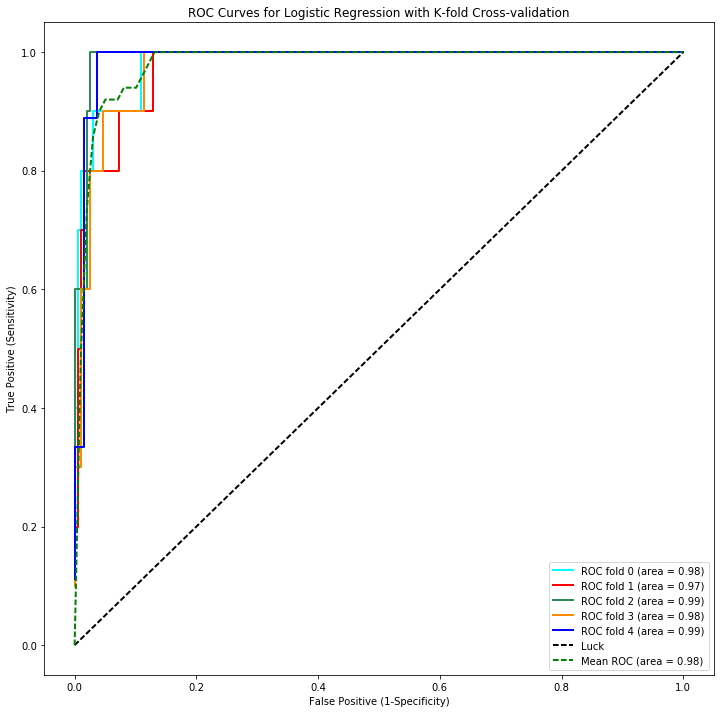

In [12]:
# Plot the ROC Curve for logistic regression
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')

num_cv_splits = cv.get_n_splits(X, y) #5

mean_tpr /= num_cv_splits
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive (1-Specificity)')
plt.ylabel('True Positive (Sensitivity)')
plt.title('ROC Curves for Logistic Regression with K-fold Cross-validation')
plt.legend(loc="lower right")

# change size of plot
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.show()